# Layout code

To be submitted to Daniel Teal for processing (thanks!), few device iterations and trials

Date: 09/17/2021

Purpose: Preliminary rotary test structures, documentation for the purpose of each of them is found below

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import dynamics.motor_analysis as analysis
import layout.motor_tools as tools
import gdspy
import numpy as np
import generator as generator

In [3]:
from IPython.display import SVG ##to display layout directly

In [4]:
lib = gdspy.GdsLibrary()

## GCA different params


In [5]:

num_fingers = [20, 40, 60]
lengths = [40, 60, 80]
gcas = np.empty((len(num_fingers), len(lengths)), dtype = gdspy.Cell)
for i, N in enumerate(num_fingers):
    for j, length in enumerate(lengths):
        gca = tools.GCA(None, lib,N, finger_length= length, layer =tools.SOI)
        gca.draw()
        metal = gdspy.offset(gca.flexure_ref, -10, layer = tools.METAL, datatype= 0, join_first= True)
        metal2 = gdspy.offset(gca.stator, -10, layer = tools.METAL, datatype= 0, join_first= True)
        gca.add((metal, metal2))
        interconnect = gdspy.FlexPath([(60+length,150), (400,150), (400, -125), (-(180+length),-125), (-(180+length), 100), (-(60+length), 100)], width = 70, layer = tools.SOI, datatype= 0 ).to_polygonset()
        metal3 = gdspy.offset(interconnect, -10, layer= tools.METAL, datatype=0)
        gca.add((interconnect, metal3))
        
        tools.add_trench(gca, 40, 100)
        
        rect = gdspy.Rectangle((-220 - gca.finger_length,36.8), (-30-gca.finger_length, 236.8), layer = tools.SOI, datatype= 0)
        gca.add(rect)
        rect = gdspy.offset(rect, -10, layer = tools.METAL, datatype=0)
        gca.add(rect)
        # name = tools.myText('MB, Run: DT1', 50, gca.get_contact_point()[0] + np.array([-250, 50]),  layer = tools.METAL)
        not_dummy = tools.compute_anchors(gca, -10, layer= tools.SOI, output_layer = tools.NOT_DUMMY, output_datatype=0)
        topanchor_bb = gca.flexure_ref[1].get_bounding_box() + np.array([gca.flexure_ref[1].ref_cell.spring_length, -30])
        rect = gdspy.Rectangle(topanchor_bb[0,:],topanchor_bb[0,:]+ np.array([200, 200]), layer = tools.SOI, datatype= 0 )
        gca.add(rect)
        rect = gdspy.offset(rect, -10, layer = tools.METAL, datatype=0)
        gca.add(rect)
        text_loc = np.array([gca.get_bounding_box()[0,0] + 80, gca.get_bounding_box()[1,1]-120])
        text = tools.myText(f'N = {N},\nl = {gca.finger_length:.0f}u', 40, text_loc, layer = tools.METAL)
        gca.add(text)
        # gca.add(name)
        gcas[i,j] = gca

In [6]:
gcas_cell = lib.new_cell('GCA_cells', overwrite_duplicate=True, update_references=True)
for (i,j), gca in np.ndenumerate(gcas):
    ref = gdspy.CellReference(gca, (1000*j, 1200*i))
    gcas_cell.add(ref)

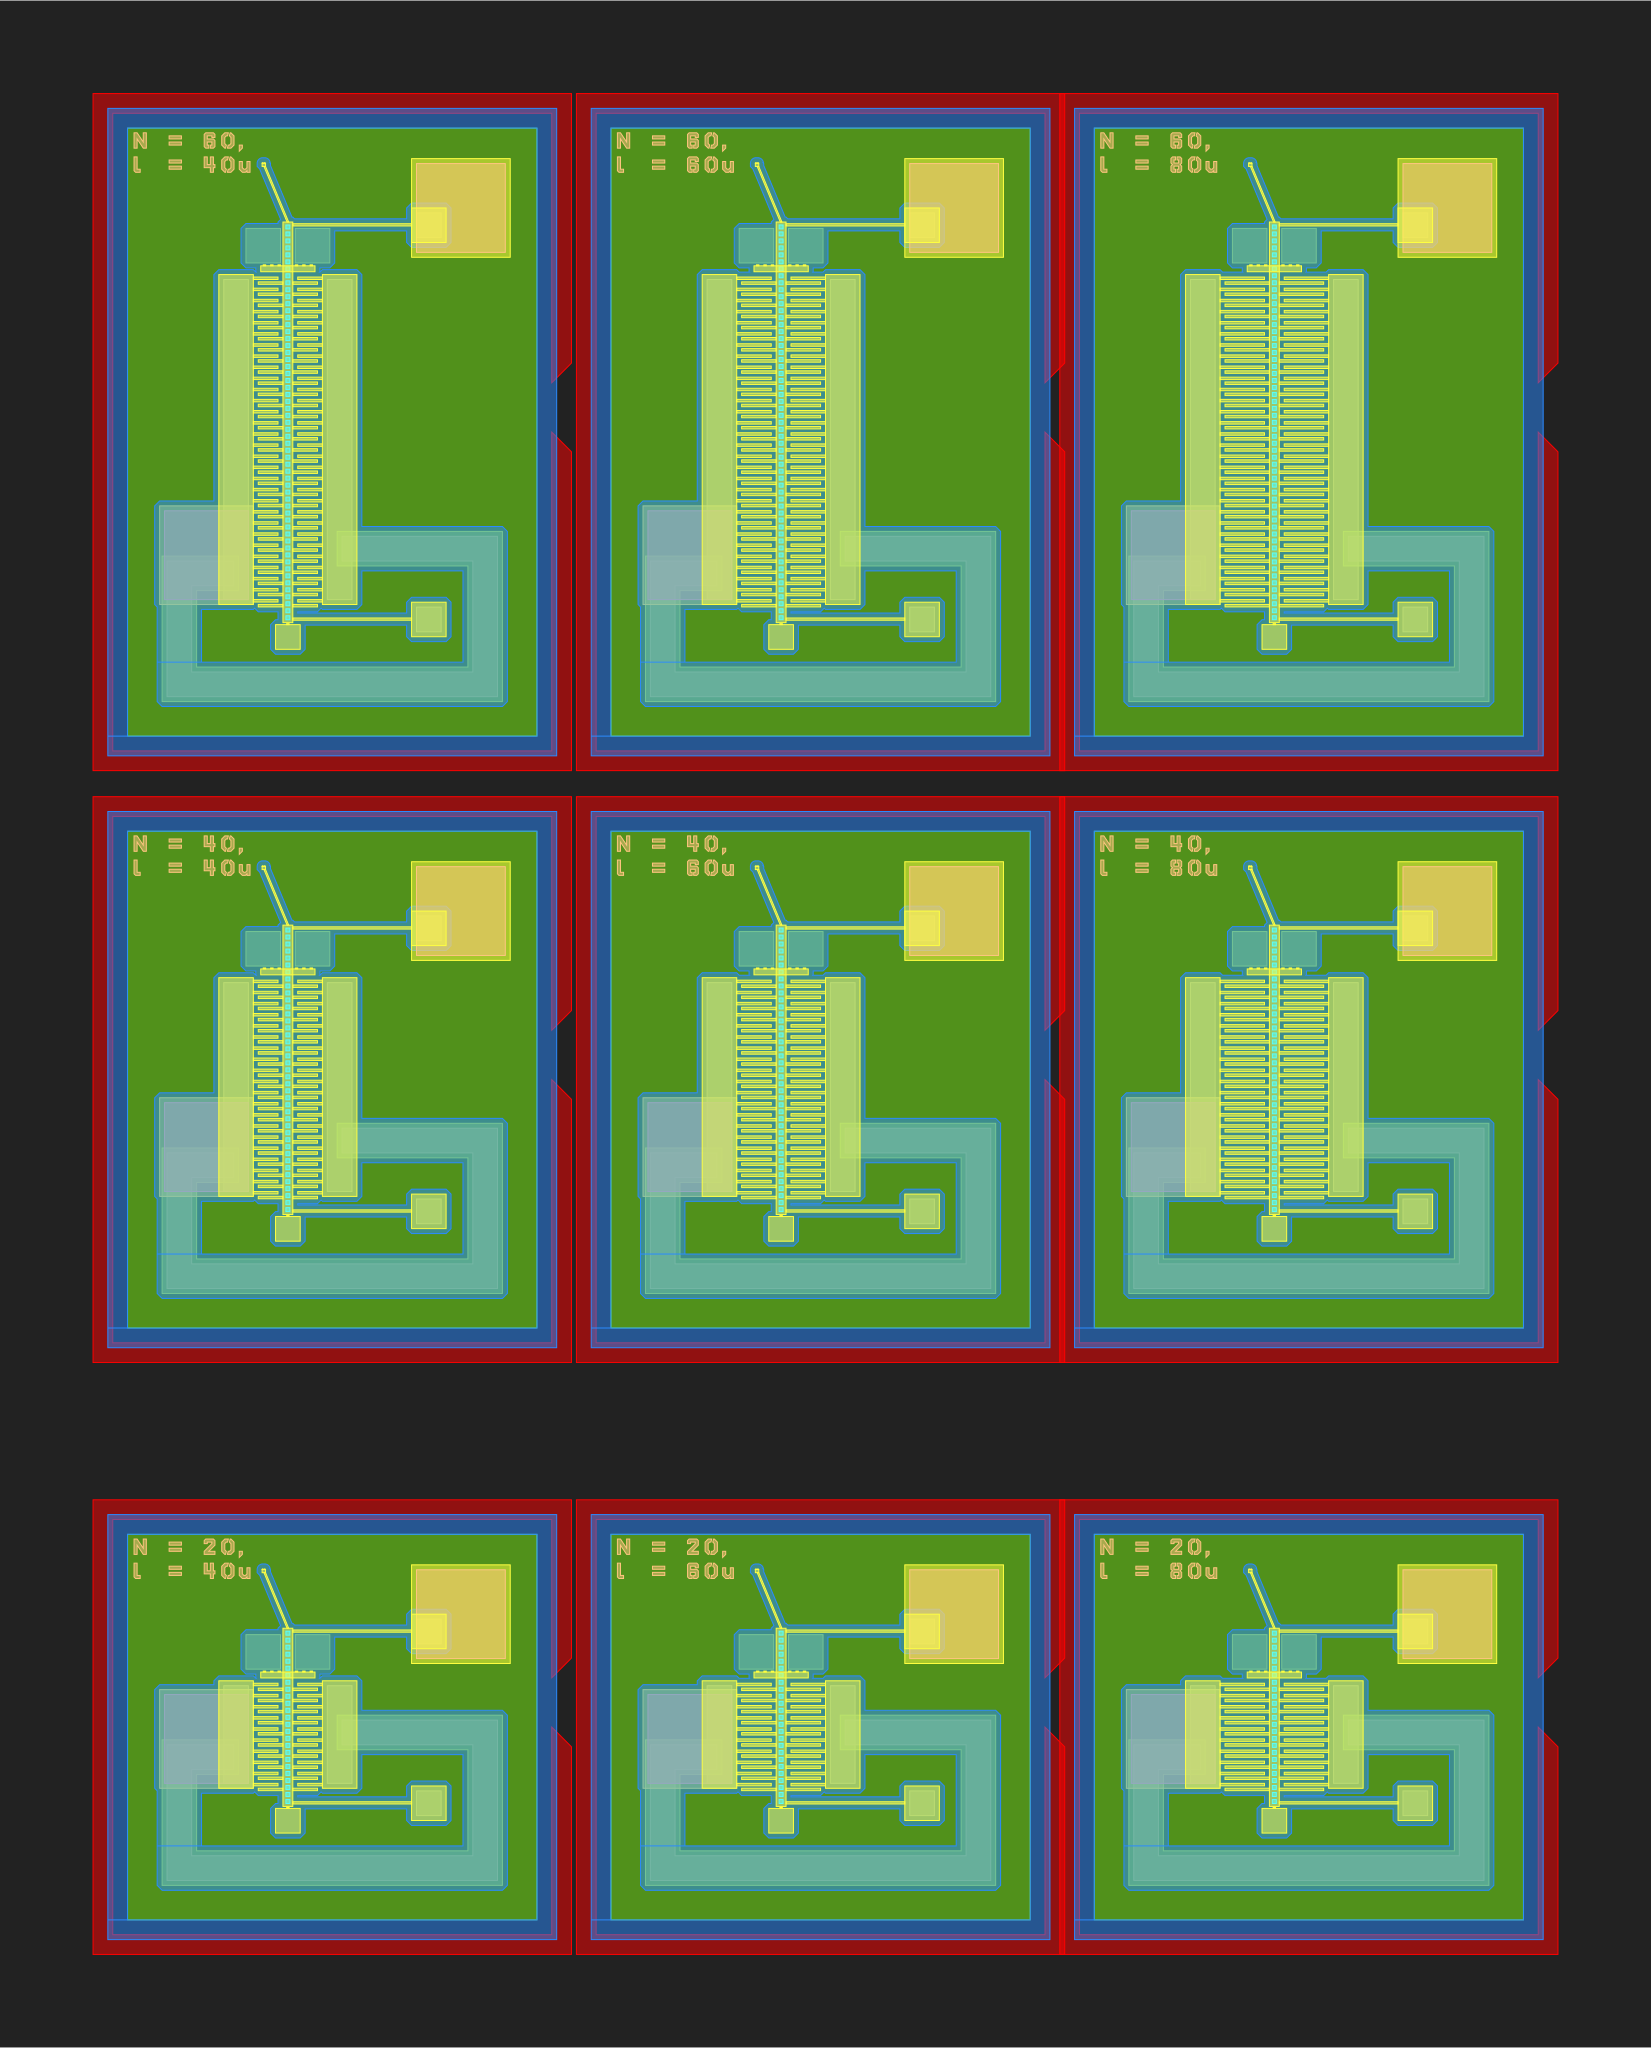

In [7]:
i=0
filename = 'temp.svg'
gcas_cell.write_svg(filename, scaling = 0.5)
SVG(filename=filename)

In [8]:
shuttle = tools.RotShuttle(None, lib, (0,0), 100, 200, etch_size=8, etch_hole_params={'num_of_points': 12})
shuttle.draw_shuttle()
shuttle.draw_teeth(tooth_extension=0.5)
shuttle.spiralspring(100, 2, 100)
shuttle.spiral.opposite_spring()
shuttle.spiral.opposite_spring(np.pi/2)
shuttle.spiral.opposite_spring(-np.pi/2)

7
8
9
10
11
12
13
14
22.590049999999998 22.590049999999998
[ 14.16605098 -58.30371343] [ 0.23610085 -0.97172856]


In [9]:
rotor = tools.GCA(None, lib, 50, anchor_width=100)
rotor.draw()
metal = gdspy.offset(rotor.flexure_ref, -10, layer = tools.METAL, datatype= 0, join_first= True)
metal2 = gdspy.offset(rotor.stator, -10, layer = tools.METAL, datatype= 0, join_first= True)
rotor.add((metal, metal2))
interconnect = gdspy.FlexPath([(60+length,150), (400,150), (400, -125), (-(180+length),-125), (-(180+length), 100), (-(60+length), 100)], width = 70, layer = tools.SOI, datatype= 0 ).to_polygonset()
metal3 = gdspy.offset(interconnect, -10, layer= tools.METAL, datatype=0)
rotor.add((interconnect, metal3))
topanchor_bb = rotor.flexure_ref[1].get_bounding_box()



full_motor = tools.RotMotor(None, lib, rotor, shuttle, 4)
full_motor.draw_gcas()

202.75
pawl pos [ 1.24148569e-14 -2.02750000e+02]
pawl pos [202.75   0.  ]
pawl pos [1.24148569e-14 2.02750000e+02]
pawl pos [-2.02750000e+02  2.48297139e-14]


In [10]:
not_dummy = tools.compute_anchors(full_motor, -20, layer= tools.SOI, output_layer = tools.NOT_DUMMY, output_datatype=0)
rect = gdspy.Rectangle(topanchor_bb[1,:] + np.array([-100,0]),topanchor_bb[1,:]+ np.array([100, -200]), layer = tools.SOI, datatype= 0 )
rotor.add(rect)
rect = gdspy.offset(rect, -10, layer = tools.METAL, datatype=0)
rotor.add(rect)

label = tools.myText('M. Bustamante\n 23sep2021 \n rot motor', 50, (500,1000), layer = tools.SOI_HOLE )
rect = gdspy.Rectangle(label.get_bounding_box()[0,:], label.get_bounding_box()[1,:], layer = tools.NOT_DUMMY)
rect = gdspy.offset(rect, 20, layer = tools.SOI)
full_motor.add(rect)
full_motor.add(label)
tools.add_trench(full_motor)

(<gdspy.polygon.PolygonSet at 0x15f3f161d00>,
 <gdspy.polygon.PolygonSet at 0x15f3d071ec0>)

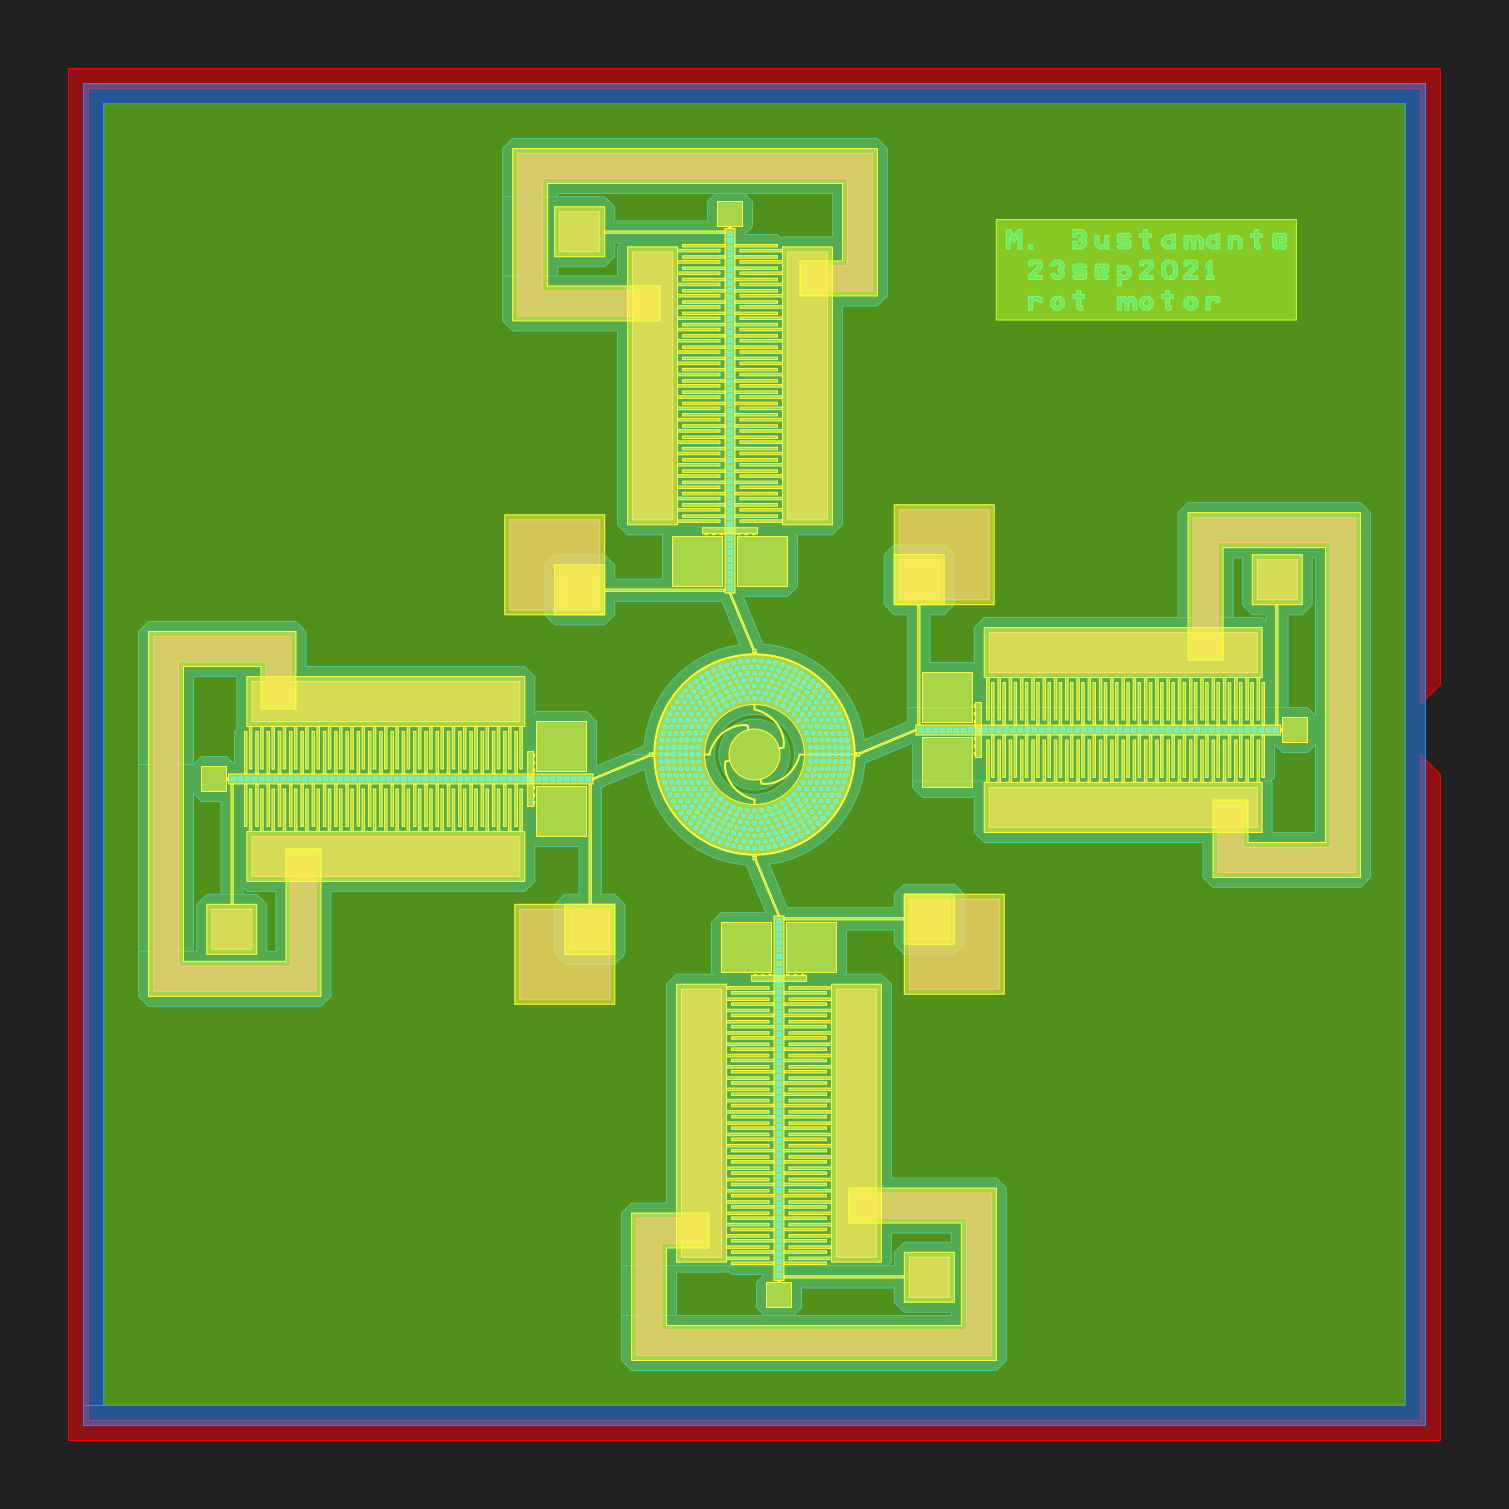

In [11]:
filename = 'temp.svg'
full_motor.write_svg(filename, scaling = 0.5)
SVG(filename=filename)

# save as gds  

In [12]:
lib.write_gds('raw_layout.gds')